<a href="https://colab.research.google.com/github/Alinka7/Deep-Learning/blob/main/ready_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras import layers
# from tensorflow.keras.utils import plot_model
import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
# from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
# from tensorflow.keras.models import Model
# from tensorflow.keras import regularizers
# from tensorflow.keras.utils import plot_model
import tensorflow as tf
# Common
import keras
import numpy  as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from numpy import zeros, random

# Data
# from tensorflow.image import resize
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Data viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPool2D, Dropout, BatchNormalization, Layer, Input, add, multiply, UpSampling2D


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
root_path = '/content/drive/MyDrive/Colab Notebooks/t/images/'
image_paths = sorted(glob(root_path + f"*.png"))
mask_paths = []
for path in image_paths:
    mask_path = path.replace('images','segmentations')
    mask_path = mask_path.replace('.png','_seg0.png')
    mask_paths.append(mask_path)
print(f"Total Number of Images  : {len(image_paths)}")

Total Number of Images  : 832


In [ ]:
def load_image(path):
    img = resize( img_to_array( load_img(path) )/255. , (256,256))
    return img

In [ ]:
from numpy import zeros, random
images = zeros(shape=(len(image_paths), 256, 256, 3))
masks = zeros(shape=(len(image_paths), 256, 256, 3))
for n, (img_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), desc="Loading"):
    images[n] = load_image(img_path)
    masks[n] = load_image(mask_path)

imagesTrain = images[:700]
masksTrain = masks[:700]

imagesTest = images[700:]
masksTest = masks[700:]

Loading: 832it [05:16,  2.63it/s]


In [ ]:
# strcture of MobileNetV2 
# MobileNetV2 - це архітектура нейронної мережі, яка використовується для класифікації зображень. Вона має дві основні частини: спочатку зображення зменшується до меншого розміру за допомогою свертки з ядром 3x3 з кроком 2, щоб зменшити обчислювальні витрати. Потім застосовуються повторювані блоки, які складаються з точкової свертки, свертки з ядром 3x3 та блоку підвищення роздільної здатності. Останній блок містить одиниці Global Average Pooling та softmax-функцію для класифікації. MobileNetV2 має високу швидкість роботи та високу точність на задачах класифікації зображень.


In [ ]:
# load the pretrained model MobileNetV2 
# include_top = True - includes the final cassification layer, which is trained to recognize 1000 classes of objects in the ImageNet dataset
# use pre-trained ImageNet weights
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
# the weights of the pre-trained model will not be updated during training (because I use pre-trained ImageNet weights)
pretrained_model.trainable = False

# ImageNet labels
# decode the predictions made by a MobileNetV2 model that has been trained on the ImageNet dataset
# Ця функція отримує на вхід список передбачень, де кожне передбачення представлено як одновимірний масив NumPy довжиною 1000, що містить ймовірності належності зображення до кожного з 1000 класів ImageNet. Потім функція повертає список кортежів, де кожний кортеж містить ідентифікатор класу, назву класу та ймовірність відповідного передбачення.
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 [==============================] - 0s 0us/step


In [ ]:
# preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.convert_to_tensor(image)
  image = tf.cast(image, tf.float32) # convert to float32 data type
  image = tf.image.resize(image, (224, 224)) # the size of the input image to MobileNetV2 must be (224, 224)
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image*255) # prepocess function of the MobileNetV2 model
  # this function makes data suitable for use with the MobileNetV2: scaling the pixel values to the range [-1, 1], normalizing, move from RGB to BGR
  image = tf.expand_dims(image, axis=0)# adds an extra dimension to the beginning of the image array.
  # This is often used when processing a single image with a neural network that expects a batch of images as input
  return image

# extract label from probability vector which is the best for the image
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [ ]:
# function fo displaying the image with predicted label
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image)) #get label of images, the level of confidence
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5) # displaying the imgage 
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description, # adding extra info
                                                   label, confidence*100))
  plt.show()

In [ ]:
elem = imagesTrain[0] # take one image like an examle
data = preprocess(elem) # preprocess this image fot using MobileNetV2
preds = pretrained_model.predict(data) # to predict class for butterfly
_, label, _ = get_imagenet_label(preds) # extract the name of the butterfly
admiral_class_index = np.argmax(preds[0])

35363/35363 [==============================] - 0s 0us/step


In [ ]:
# градієнт функції втрат а допомогою якої ми навчаємось 
# задача: а допомогою знаку градієта рухати функцію в іншу сторону

In [ ]:
# CategoricalCrossentropy loss function which is used in classification problems
# Функція втрати CategoricalCrossentropy зазвичай використовується в задачах класифікації, де вихід моделі є розподілом ймовірностей по заданому набору класів. Вона використовується для обчислення втрат між передбаченими ймовірностями класів та справжніми мітками класів.
# Буде використовуватися для обчислення втрат між передбаченими ймовірностями класів та справжніми мітками класів під час навчання моделі.
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image) 
    prediction = pretrained_model(input_image) # make class prediction for the input image
    loss = loss_object(input_label, prediction) # calculate loss between input_label and predicted label

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

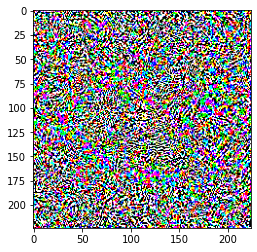

In [ ]:
# Get the input label of the image.
label = tf.one_hot(admiral_class_index, preds.shape[-1])  # creates a one-hot tensor for the class index admiral_class_index in the classification output 
                                                          # with a length equal to the number of classes in the model (1000)
label = tf.reshape(label, (1, preds.shape[-1])) # reshape the one-hot tensor to have a shape of (1, num_classes) == (1, 1000)

perturbations = create_adversarial_pattern(data, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # to change [-1, 1] to [0,1]

1/1 [==============================] - 0s 106ms/step


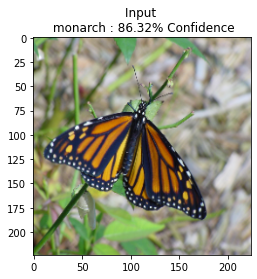

1/1 [==============================] - 0s 89ms/step


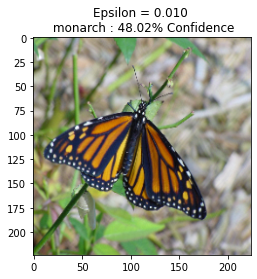

1/1 [==============================] - 0s 95ms/step


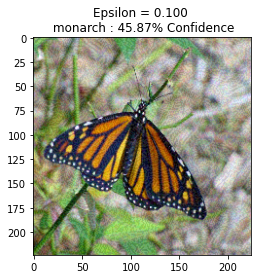

1/1 [==============================] - 0s 95ms/step


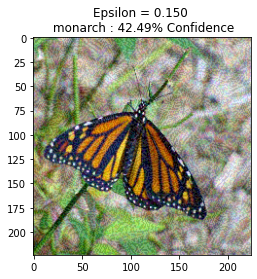

1/1 [==============================] - 0s 130ms/step


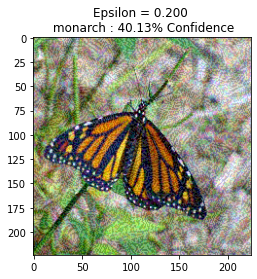

1/1 [==============================] - 0s 95ms/step


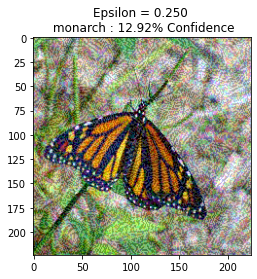

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15, 0.2, 0.25] # choose epsilon - multiplier to ensure small disturbances.
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = data + eps*perturbations # add this 'noise' to the image 
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])